# Exercise Chapter 3_ex 
Industrial Statistics: A Computer Based Approach with Python<br>
by Ron Kenett, Shelemyahu Zacks, Peter Gedeck

Publisher: Springer International Publishing; 1st edition (2023) <br>
<!-- ISBN-13: 978-3031075650 -->

(c) 2022 Ron Kenett, Shelemyahu Zacks, Peter Gedeck

The code needs to be executed in sequence.

In [1]:
import os
os.environ['OUTDATED_IGNORE'] = '1'
import warnings
from outdated import OutdatedPackageWarning
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=OutdatedPackageWarning)

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.special import factorial
import statsmodels.formula.api as smf
import mistat
import matplotlib.pyplot as plt

# Exercise 1

In [3]:
from scipy.special import binom
def probRuns(m1, m2, R):
    n = m1 + m2
    k = R // 2
    if R % 2:
        denom = binom(m1-1,k-1) * binom(m2-1,k) + binom(m1-1,k) * binom(m2-1,k-1)
        return denom / binom(n, m2)
    else:
        return 2 * binom(m1-1, k-1) * binom(m2-1, k-1) / binom(n, m2)

In [4]:
n = 25
m2 = 10
m1 = n - m2

df = pd.DataFrame({
    'R': range(0, n+1),
    'p.d.f': [probRuns(m1, m2, R) for R in range(0, n+1)],
})
df['c.d.f'] = np.cumsum(df['p.d.f'])

In [5]:
cdf = df['c.d.f'].values

Q1 = np.where(cdf < 0.25)[0][-1]
Me = np.where(cdf < 0.5)[0][-1]
Q3 = np.where(cdf < 0.75)[0][-1]
print(Q1, Me, Q3)

10 12 14


In [6]:
mu_R = 1 + 2 * m1 * m2 / n
sigma_R = np.sqrt(2*m1*m2*(2*m1*m2 - n) / (n*n*(n-1)))
print(mu_R, sigma_R)

13.0 2.345207879911715


In [7]:
p = df['c.d.f'][16] - df['c.d.f'][9]
print(p)

0.8656750572082381


In [8]:
print(stats.norm.cdf((16.5-mu_R)/sigma_R) - stats.norm.cdf((9.5-mu_R)/sigma_R))

0.8644069987336978


# Exercise 2

In [9]:
data = mistat.load_data('CYCLT')
# convert to up (1) or down (0) information relative to mean
mean_ct = np.mean(data)
runs = [1 if ct > mean_ct else 0 for ct in data]

# determine number of runs
obs_Runs = 0
current = None
for r in runs:
    if r != current:
        obs_Runs += 1
        current = r
print(f'Observed number of runs: {obs_Runs}')

# calculate expected number of runs
m1 = sum(data > mean_ct)
m2 = sum(data <= mean_ct)
n = m1 + m2
mu_R = 1 + 2 * m1 * m2 / n
print(f'Expected number of runs {mu_R:.2f}')

# determine if difference is significant
mistat.runsTest(data, cutoff=np.mean(data))

Observed number of runs: 26
Expected number of runs 25.64


Result(statistic=0.1044134517056721, pval=0.9168412481142088, method='Runs Test', alternative='two.sided')

# Exercise 3

In [10]:
n = 50
mu_Rstar = (2*n-1)/3
print(mu_Rstar)

33.0


In [11]:
# determine direction of change up (1) or down (-1)
y = [1 if xi < xip1 else -1 for xi, xip1 in zip(data[:-1], data[1:])]

# count number of up and down runs
up = 0
down = 0
current = None
for yi in y:
    if yi == current: # no change of direction
        continue
    if yi < 0:
        down += 1
    else:
        up += 1
    current = yi
Rstar = up + down
print(Rstar, up, down)

34 17 17


In [12]:
n = 50
mu_Rstar = (2*n-1)/3
sigma_Rstar = np.sqrt((16*n-29)/90)
print(sigma_Rstar)
alpha_L = stats.norm.cdf((Rstar-mu_Rstar)/sigma_Rstar)
alpha_U = 1 - alpha_L
print(alpha_U, alpha_L)

2.9268868558020253
0.3663034098961011 0.6336965901038989


In [13]:
def expected_R_k(n, k):
    return 2 *(n*(k+1) - k*k - k + 1)/factorial(k+2)

print(expected_R_k(50, 5))
# probability to have run greater than 5
print(1 - np.exp(-expected_R_k(50, 5)))

0.10753968253968255
0.10195911479934461


In [14]:
mistat.runStatistics(data)

{'count': {'mu_R': 25.64, 'sigma_R': 3.4478316167038754, 'observed': 26},
 'direction': {'mu_Rstar': 33.0,
  'sigma_Rstar': 2.9268868558020253,
  'up': 17,
  'down': 17,
  'Rstar': 34,
  'alpha': [0.3663034098961011, 0.6336965901038989]}}

# Exercise 4

In [15]:
data = mistat.load_data('YARNSTRG')
mistat.runStatistics(data)

{'count': {'mu_R': 50.92, 'sigma_R': 4.966642668235696, 'observed': 49},
 'direction': {'mu_Rstar': 66.33333333333333,
  'sigma_Rstar': 4.1779846284489315,
  'up': 32,
  'down': 32,
  'Rstar': 64,
  'alpha': [0.28825730949895256, 0.7117426905010474]}}

In [16]:
mistat.runsTest(data, cutoff=data.mean())

Result(statistic=-0.3865790491189181, pval=0.6990678707195341, method='Runs Test', alternative='two.sided')

# Exercise 5

In [17]:
parameter = pd.DataFrame({
    'm': [60],
    's': [0.02],
    'k': [5_000],
    't': [296],
    'p0': [110_000],
    'v0': [0.01],
    't0': [360],
})
simulator = mistat.PistonSimulator(parameter=parameter, n_simulation=50, n_replicate=5, seed=1236)
# simulator = mistat.PistonSimulator(n_simulation=50, n_replicate=5, seed=1)
Ps = simulator.simulate()

# get grouped cycle times
cycleTime = mistat.qcc_groups(Ps['seconds'], Ps['group'])
mistat.runsTest(np.mean(cycleTime, axis=1), np.mean(cycleTime))

Result(statistic=-0.5610330087428953, pval=0.5747750350233831, method='Runs Test', alternative='two.sided')

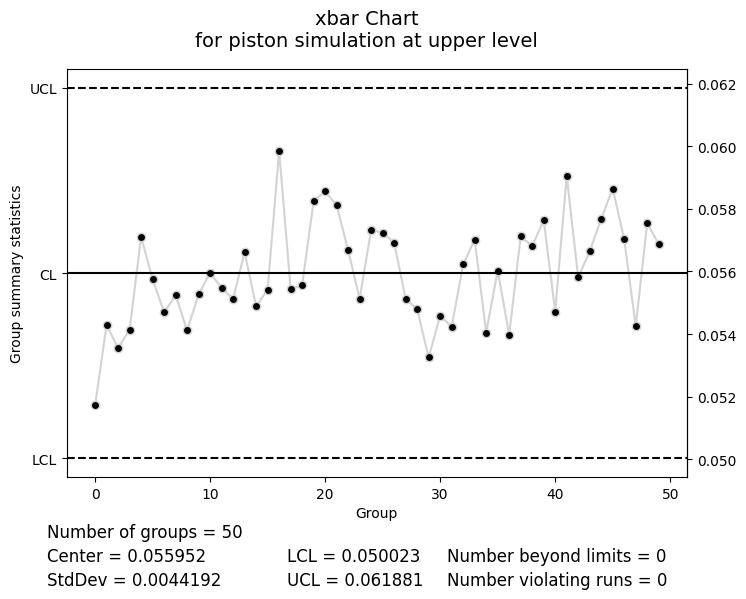

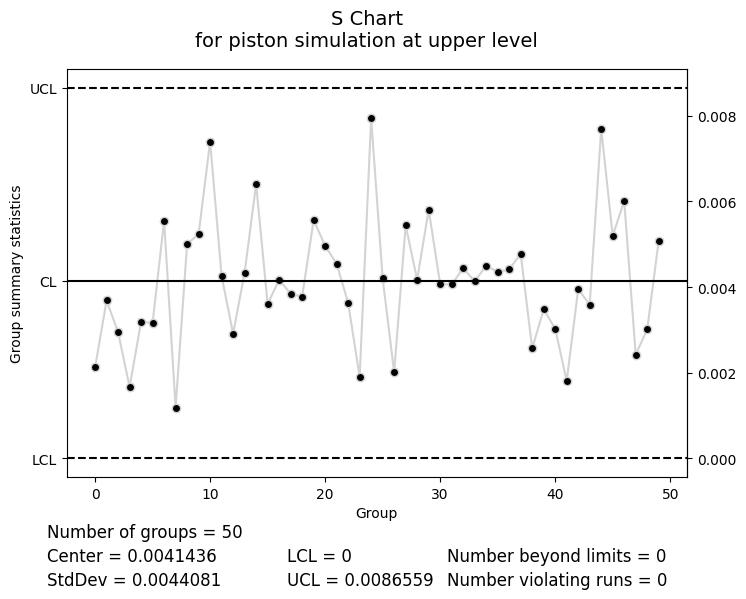

In [18]:
qcc = mistat.QualityControlChart(cycleTime, qcc_type='xbar')
ax = qcc.plot(title='for piston simulation at upper level')
plt.show()
qcc = mistat.QualityControlChart(cycleTime, qcc_type='S')
ax = qcc.plot(title='for piston simulation at upper level')
plt.show()

# Exercise 6

In [19]:
parameter = pd.DataFrame({
    'm': [60]*50,
    's': [0.02]*50,
    'k': [5_000]*50,
    't': [296] * 16 + [296 * 1.1**i for i in range(1, 35)],
    'p0': [110_000]*50,
    'v0': [0.01]*50,
    't0': [360]*50,
})

simulator = mistat.PistonSimulator(parameter=parameter, n_simulation=50, 
                                   n_replicate=5, seed=1, check=False)
Ps = simulator.simulate()
cycleTimeTshift = mistat.qcc_groups(Ps['seconds'], Ps['group'])

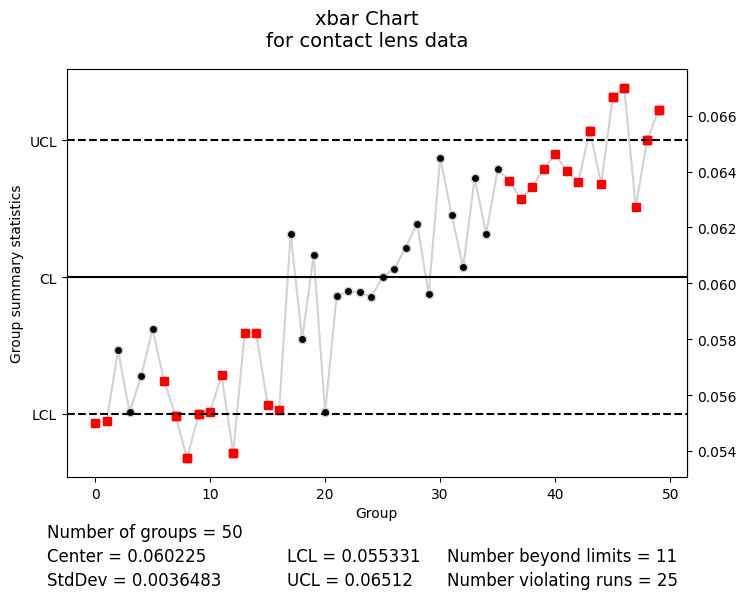

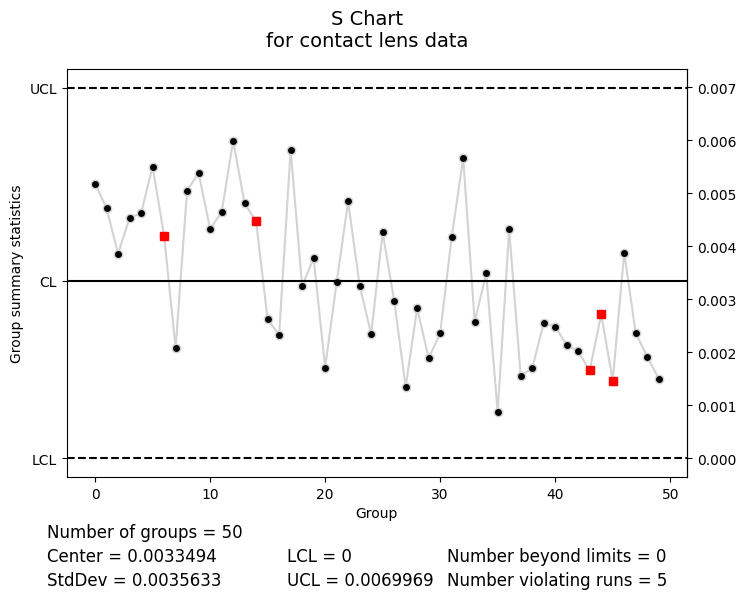

In [20]:
qcc = mistat.QualityControlChart(cycleTimeTshift, qcc_type='xbar')
ax = qcc.plot(title='for contact lens data')
plt.show()
qcc = mistat.QualityControlChart(cycleTimeTshift, qcc_type='S')
ax = qcc.plot(title='for contact lens data')
plt.show()

In [21]:
mistat.runStatistics(np.mean(cycleTime, axis=1))

{'count': {'mu_R': 25.96, 'sigma_R': 3.493555583105112, 'observed': 24},
 'direction': {'mu_Rstar': 33.0,
  'sigma_Rstar': 2.9268868558020253,
  'up': 16,
  'down': 16,
  'Rstar': 32,
  'alpha': [0.36630340989610105, 0.6336965901038989]}}

In [22]:
mistat.runStatistics(np.mean(cycleTimeTshift, axis=1))

{'count': {'mu_R': 25.96, 'sigma_R': 3.493555583105112, 'observed': 8},
 'direction': {'mu_Rstar': 33.0,
  'sigma_Rstar': 2.9268868558020253,
  'up': 15,
  'down': 14,
  'Rstar': 29,
  'alpha': [0.08586912144778469, 0.9141308785522153]}}

In [23]:
mistat.runStatistics(np.mean(cycleTime, axis=1))

{'count': {'mu_R': 25.96, 'sigma_R': 3.493555583105112, 'observed': 24},
 'direction': {'mu_Rstar': 33.0,
  'sigma_Rstar': 2.9268868558020253,
  'up': 16,
  'down': 16,
  'Rstar': 32,
  'alpha': [0.36630340989610105, 0.6336965901038989]}}

In [24]:
mistat.runStatistics(np.mean(cycleTimeTshift, axis=1))

{'count': {'mu_R': 25.96, 'sigma_R': 3.493555583105112, 'observed': 8},
 'direction': {'mu_Rstar': 33.0,
  'sigma_Rstar': 2.9268868558020253,
  'up': 15,
  'down': 14,
  'Rstar': 29,
  'alpha': [0.08586912144778469, 0.9141308785522153]}}

In [25]:
print('mean:', mistat.runsTest(np.mean(cycleTime, axis=1), np.mean(cycleTime)).pval)
STD = np.std(cycleTime, axis=1)
print('std:', mistat.runsTest(STD, np.mean(STD)).pval)

mean: 0.5747750350233831
std: 0.2529990614746843


In [26]:
print('mean:', mistat.runsTest(np.mean(cycleTimeTshift, axis=1), np.mean(cycleTimeTshift)).pval)
STD = np.std(cycleTimeTshift, axis=1)
print('std:', mistat.runsTest(STD, np.mean(STD)).pval)

mean: 2.7343384749349e-07
std: 0.09297787599834818


# Exercise 7

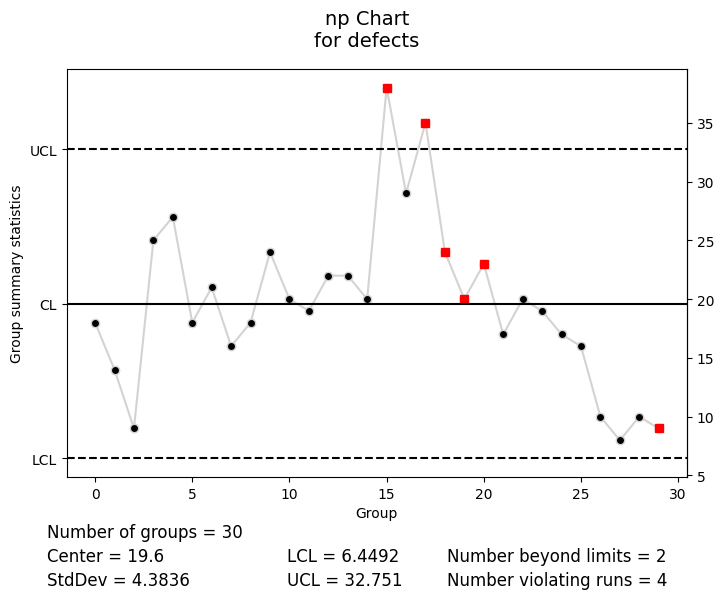

In [27]:
data = pd.Series([18, 14,  9, 25, 27, 18, 21, 16, 18, 24, 20, 19, 22, 22, 20, 
        38, 29, 35, 24, 20, 23, 17, 20, 19, 17, 16, 10,  8, 10,  9])

qcc = mistat.QualityControlChart(data, qcc_type='np', sizes=1000)
ax = qcc.plot(title='for defects')
plt.show()

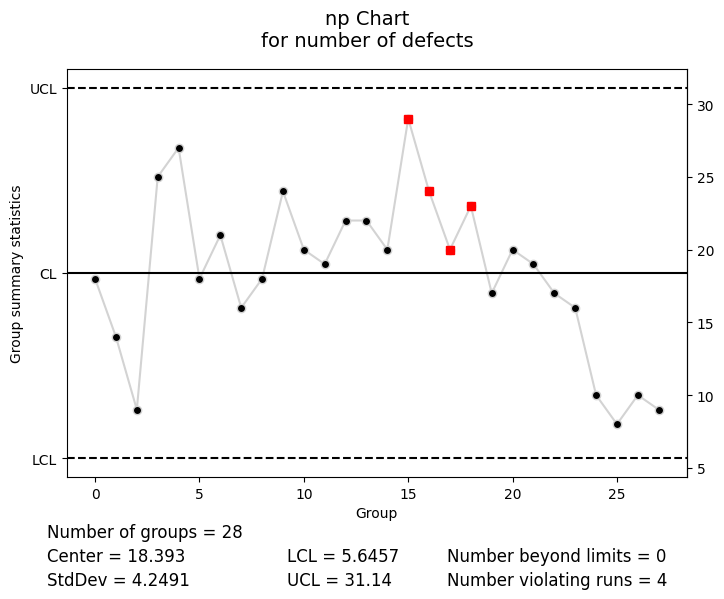

In [28]:
revised = data[data < 32.751]

qcc = mistat.QualityControlChart(revised, qcc_type='np', sizes=1000)
ax = qcc.plot(title='for number of defects')
plt.show()

# Exercise 8

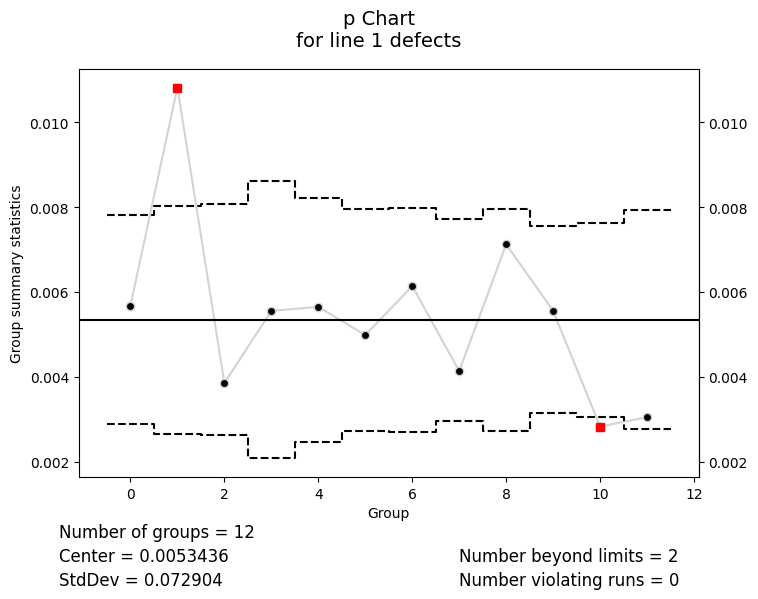

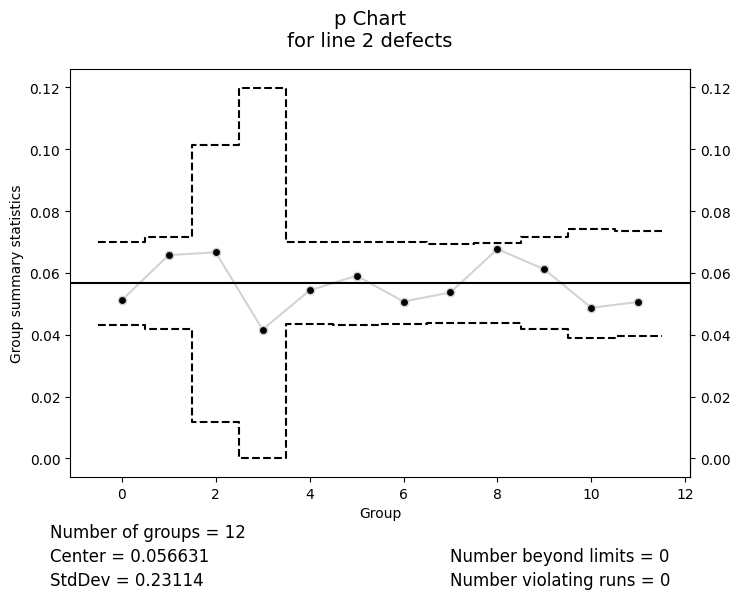

In [29]:
data = pd.DataFrame([
    [1, 45, 7920, 135, 2640],
    [2, 72, 6660, 142, 2160], 
    [3, 25, 6480,  16,  240],
    [4, 25, 4500,   5,  120],
    [5, 33, 5840, 150, 2760],
    [6, 35, 7020, 156, 2640],
    [7, 42, 6840, 140, 2760],
    [8, 35, 8460, 160, 2980],
    [9, 50, 7020, 195, 2880],
    [10,55, 9900, 132, 2160],
    [11,26, 9180,  76, 1560],
    [12,22, 7200,  85, 1680]],
    columns=['Week', 'Line 1 X', 'Line 1 n', 'Line 2 X', 'Line 2 n']
)

qcc = mistat.QualityControlChart(data['Line 1 X'], qcc_type='p', sizes=data['Line 1 n'])
ax = qcc.plot(title='for line 1 defects')
plt.show()

qcc = mistat.QualityControlChart(data['Line 2 X'], qcc_type='p', sizes=data['Line 2 n'])
ax = qcc.plot(title='for line 2 defects')
plt.show()

# Exercise 10

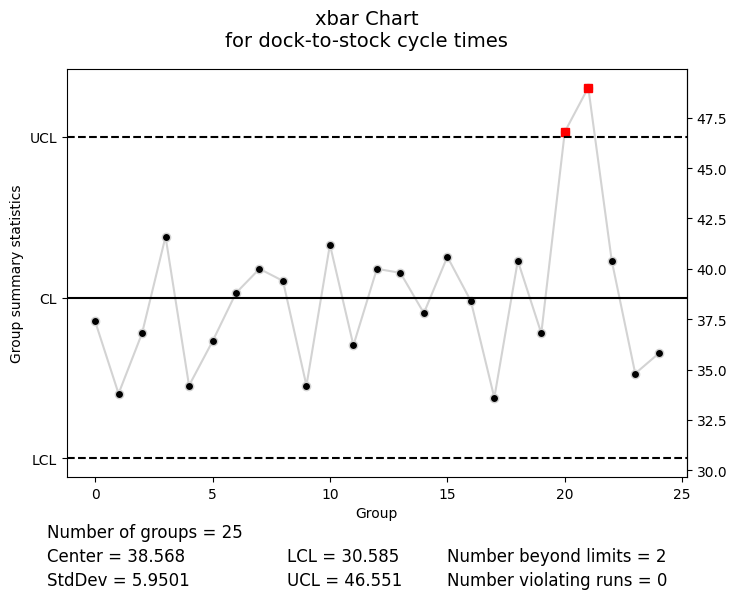

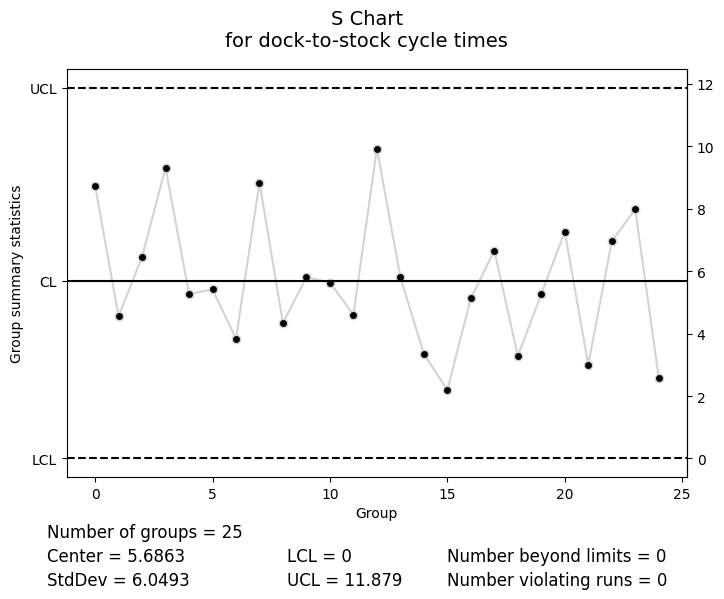

(37.756521739130434,
          LCL        UCL
 0  29.731454  45.781589)

In [30]:
cycleTime = pd.DataFrame([
    [1, 27, 43, 49, 32, 36],      [2, 34, 29, 34, 31, 41],
    [3, 36, 32, 48, 35, 33],      [4, 31, 41, 51, 51, 34],
    [5, 43, 35, 30, 32, 31],      [6, 28, 42, 35, 40, 37],
    [7, 38, 37, 41, 34, 44],      [8, 28, 44, 44, 34, 50],
    [9, 44, 36, 38, 44, 35],      [10, 30, 43, 37, 29, 32],
    [11, 36, 40, 50, 37, 43],     [12, 35, 36, 44, 34, 32],
    [13, 48, 49, 44, 27, 32],     [14, 45, 46, 40, 35, 33],
    [15, 38, 36, 43, 38, 34],     [16, 42, 37, 40, 42, 42],
    [17, 44, 31, 36, 42, 39],     [18, 32, 28, 42, 39, 27],
    [19, 41, 41, 35, 41, 44],     [20, 44, 34, 39, 30, 37],
    [21, 51, 43, 36, 50, 54],     [22, 52, 50, 50, 44, 49],
    [23, 52, 34, 38, 41, 37],     [24, 40, 41, 40, 23, 30],
    [25, 34, 38, 39, 35, 33]],
    columns=['Week', 'S1', 'S2', 'S3', 'S4', 'S5'])
cycleTime = cycleTime.set_index('Week')

qcc = mistat.QualityControlChart(cycleTime, qcc_type='xbar')
ax = qcc.plot(title='for dock-to-stock cycle times')
plt.show()

qcc = mistat.QualityControlChart(cycleTime, qcc_type='S')
ax = qcc.plot(title='for dock-to-stock cycle times')
plt.show()

# exclude points for week 21 and 22
qcc = mistat.QualityControlChart(cycleTime.drop(labels=[21, 22]), qcc_type='xbar')
qcc.center, qcc.limits

In [31]:
statistic, pvalue = stats.ttest_1samp(cycleTime.loc[21,], 45.781, alternative='greater')
print(pvalue)
statistic, pvalue = stats.ttest_1samp(cycleTime.loc[22,], 45.781, alternative='greater')
print(pvalue)

0.3846525285951686
0.03720636409199298


# Exercise 14

In [32]:
def OC_p_chart(p, n, p0):
    c = n * p0
    delta = 3 * np.sqrt(n * p0 * (1 - p0))
    return (stats.binom(n, p).cdf(c + delta) - 
            stats.binom(n, p).cdf(c - delta))
        
p = np.arange(0, 0.505, 0.05)
pd.DataFrame({'p': p, 'OC(p)': OC_p_chart(p, 20, 0.1)})

,p,OC(p)
0,0.00,1.000000
1,0.05,0.999966
2,0.10,0.997614
3,0.15,0.978065
4,0.20,0.913307
5,0.25,0.785782
6,0.30,0.608010
7,0.35,0.416625
8,0.40,0.250011
9,0.45,0.129934


# Exercise 15

In [33]:
n = 1
while OC_p_chart(0.05, n, 0.01) > 0.1:
    n += 1
n

184

In [34]:
# normal approximation
def OC_p_chart_normal(p, n, p0):
    loc = n * p
    scale = np.sqrt(n*p*(1-p))
    c = n * p0
    delta = 3 * np.sqrt(n * p0 * (1 - p0))
    return (stats.norm(loc, scale).cdf(c + delta) - 
            stats.norm(loc, scale).cdf(c - delta))

# alternative implementation
def OC_p_chart_normal_2(p, n, p0):
    delta = 3 * np.sqrt(p0 * (1 - p0) / n)
    UCL = p0 + delta
    LCL = p0 - delta
    denom = np.sqrt(p * (1 - p) / n)
    return (stats.norm().cdf((UCL - p)/denom) - 
            stats.norm().cdf((LCL - p)/denom))

n = 1
while OC_p_chart_normal(0.05, n, 0.01) > 0.1:
    n += 1
print(n, OC_p_chart_normal(0.05, n, 0.01))

209 0.09959381959080052


# Exercise 17

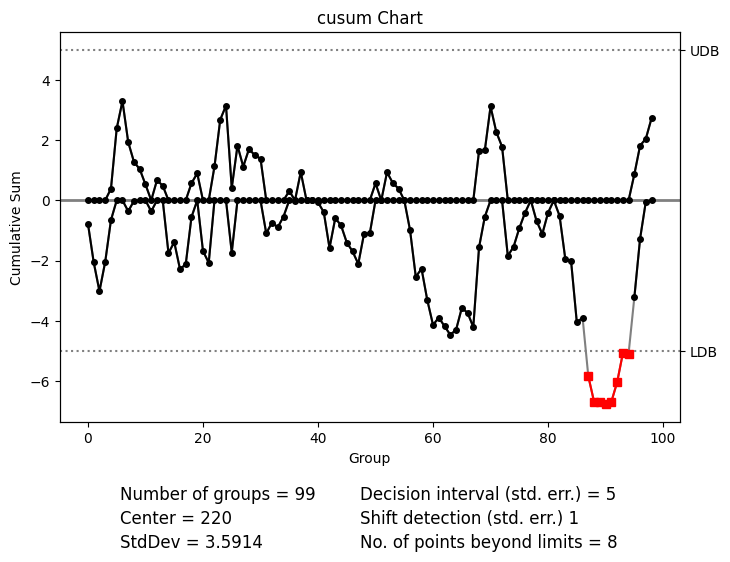

In [35]:
data = mistat.load_data('OELECT')
analysis = mistat.Cusum(data, center=220)
analysis.plot()
plt.show()

# Exercise 18

In [36]:
lambda0 = 15
lambda1_p = 25
lambda1_m = 7
alpha = 0.001
tau = 30
kp = (lambda1_p - lambda0) / np.log(lambda1_p/lambda0)
hp = - np.log(alpha) / np.log(lambda1_p/lambda0)

km = (lambda1_m - lambda0) / np.log(lambda1_m/lambda0)
hm = - np.log(alpha) / np.log(lambda1_m/lambda0)

arl = mistat.cusumPfaCed(randFunc1=stats.poisson(mu=15), 
                         randFunc2=stats.poisson(mu=25), 
                         tau=tau,
                         kp=kp, km=km,
                         hp=hp, hm=hm,
                         N=4000, limit=1000, seed=1)
result = arl['statistic']

PFA 0.01075  CED 2.1663  Std. Error 0.51072


# Exercise 19

In [37]:
mu0 = 100
mu1p = 110
mu1m = 90
sigma = 20
n = 5
alpha = 0.001

Kp = (mu0+mu1p)/2
hp = -(sigma**2 / n) * np.log(alpha) / (mu1p-mu0)
Km = (mu0+mu1m)/2
hm = -(sigma**2 / n) * np.log(alpha) / (mu1m-mu0)

pd.Series({'Kp': Kp, 'hp': hp, 'Km': Km, 'hm': hm})

Kp    105.000000
hp     55.262042
Km     95.000000
hm    -55.262042
dtype: float64

In [38]:
results = []
for tau in [10, 20, 30]:
    arl = mistat.cusumPfaCed(randFunc1=stats.norm(loc=mu0, scale=sigma/np.sqrt(5)), 
                             randFunc2=stats.norm(loc=mu1p, scale=sigma/np.sqrt(5)), 
                             tau=tau, kp=Kp, km=Km, hp=hp, hm=hm,
                             N=300, limit=1000, seed=1, verbose=False)
    results.append({
        'tau': tau,
        **arl['statistic'], # copy all results from arl['statistic']
    })
pd.DataFrame(results)

,tau,PFA,CED,Std. Error
0,10,0.000000,10.090000,1.050516
1,20,0.003333,10.076923,1.671984
2,30,0.006667,10.449664,2.289643


In [39]:
n = 20
hp = -(sigma**2 / n) * np.log(alpha) / (mu1p-mu0)
hm = -(sigma**2 / n) * np.log(alpha) / (mu1m-mu0)

results = []
for tau in [10, 20, 30]:
    arl = mistat.cusumPfaCed(randFunc1=stats.norm(loc=mu0, scale=sigma/np.sqrt(5)), 
                             randFunc2=stats.norm(loc=mu1p, scale=sigma/np.sqrt(5)), 
                             tau=tau, kp=Kp, km=Km, hp=hp, hm=hm,
                             N=300, limit=1000, seed=1, verbose=False)
    results.append({
        'tau': tau,
        **arl['statistic'], # copy all results from arl['statistic']
    })
pd.DataFrame(results)

,tau,PFA,CED,Std. Error
0,10,0.586667,1.709677,1.056345
1,20,0.806667,2.172414,2.910490
2,30,0.920000,2.250000,6.583663


# Exercise 21

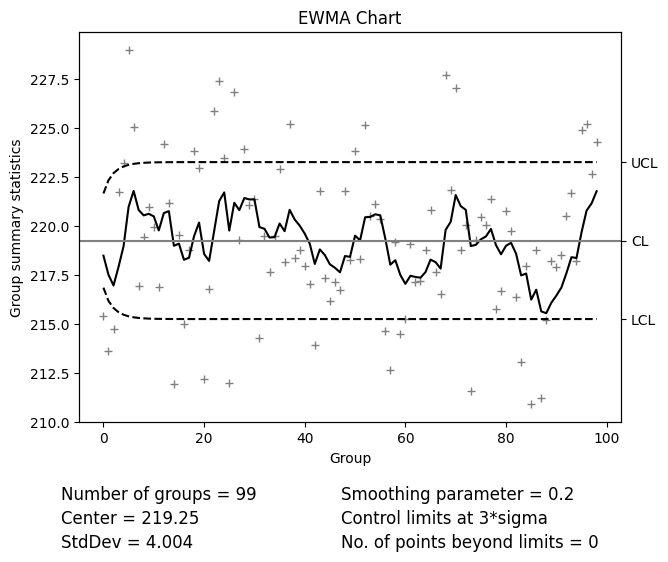

In [40]:
data = mistat.load_data('OELECT')
ewma = mistat.EWMA(data, center=data.mean(), std_dev=data.std(), 
                   sizes=1, smooth=0.2, nsigmas=3)
ewma.plot()
plt.show()

# Exercise 22

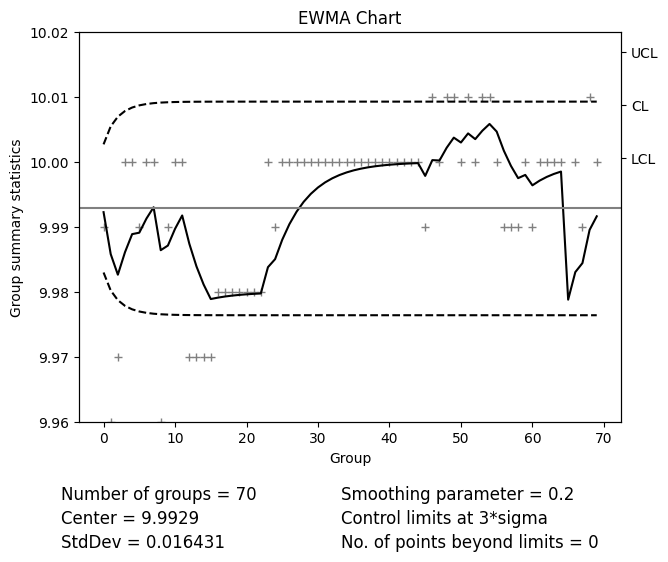

In [41]:
data = mistat.load_data('ALMPIN')
data = data['diam1']
ewma = mistat.EWMA(data, center=data.mean(), std_dev=data.std(), 
                   sizes=1, smooth=0.2, nsigmas=3)
ax = ewma.plot()
ax.set_ylim(9.96, 10.02)
plt.show()

# Exercise 23

In [42]:
dow1941 = mistat.load_data('DOW1941')
# solve the regression equation
m = 50
sqrt_t = np.sqrt(range(1, m + 1))
df = pd.DataFrame({
    'Ut': dow1941[:m]/sqrt_t,
    'x1t': 1 / sqrt_t,
    'x2t': sqrt_t,
})
model = smf.ols(formula='Ut ~ x1t + x2t - 1', data=df).fit()
mu0, delta = model.params
var_eta = np.var(model.resid, ddof=2)
pd.Series({'mu0': mu0, 'delta': delta, 'Var(eta)': var_eta})

mu0         132.808555
delta        -0.255630
Var(eta)      0.297616
dtype: float64

In [43]:
# choose sig2e and w20
sig2e = 0.15
w20 = 0.0015
# apply the filter
results = []
mu_tm1 = mu0
w2_tm1 = w20
y_tm1 = mu0
for i in range(0, len(dow1941)):
    y_t = dow1941[i]
    B_t = sig2e / (var_eta + w2_tm1)
    mu_t = B_t * (mu_tm1 + delta) + (1 - B_t) * y_t # X
    results.append({
        't': i + 1,
        'y_t': y_t,
        'mu_t': mu_t,
        'B_t': B_t,
        'W2_t': w2_tm1,
    })
    w2_tm1 = B_t * (var_eta - sig2e + w2_tm1)
    mu_tm1 = mu_t
    y_tm1 = y_t
results = pd.DataFrame(results)

In [44]:
results.head(25)

,t,y_t,mu_t,B_t,W2_t
0,1,131.13,131.843566,0.501478,0.001500
1,2,130.57,130.980023,0.402799,0.074778
2,3,132.01,131.511955,0.387400,0.089580
3,4,132.40,131.959567,0.385103,0.091890
4,5,132.83,132.396733,0.384763,0.092235
5,6,133.02,132.681878,0.384712,0.092286
6,7,133.02,132.791581,0.384705,0.092293
7,8,133.39,133.061444,0.384704,0.092294
8,9,133.59,133.288321,0.384704,0.092294
9,10,133.49,133.314072,0.384704,0.092294


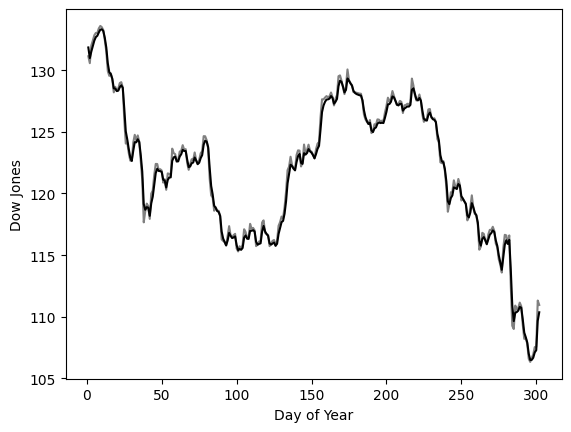

In [45]:
fig, ax = plt.subplots()
ax.plot(results['t'], results['y_t'], color='grey')
ax.plot(results['t'], results['mu_t'], color='black')
ax.set_ylabel('Dow Jones')
ax.set_xlabel('Day of Year')
plt.show()